In [8]:
# 라이브러리 import
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font="Malgun Gothic")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [9]:
data=pd.read_csv(os.listdir()[7],encoding='EUC-KR')
data_real=pd.read_csv(os.listdir()[7],encoding='EUC-KR')
data=data.query('합계!=0')
#필요 컬럼 추출
selected_columns=['비고', '지자체명_시도', '지자체명_시군구', '구분', '농업경영체','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부'] #필요한 컬럼만 추출
data=data[selected_columns]
data_real=data_real[selected_columns]
data.rename(columns={'농지면적(실제경작)':'농지면적'},inplace=True)

# 데이터 확인 및 이상치 제거

# 연속형 변수 분포 확인

이상치 제거 필요 컬럼
- 농지면적 
- 합계

In [11]:
round(data[['합계','농지면적','전년대비농경체증감률','고령농경체비율','전년도이탈인원']].describe(),3)

,합계,농지면적,전년대비농경체증감률,고령농경체비율,전년도이탈인원
count,12449.000,12449.000,12449.000,12449.000,12449.000
mean,3.395,0.496,102.359,53.464,0.092
std,2.056,0.594,0.999,4.310,0.511
min,1.000,0.000,99.500,39.370,0.000
25%,2.000,0.250,101.800,51.030,0.000
50%,3.000,0.360,102.300,53.630,0.000
75%,5.000,0.550,103.000,56.230,0.000
max,13.000,22.090,107.500,63.720,11.000


# 농지면적 이상치 제거

2.555200000000004
0.04


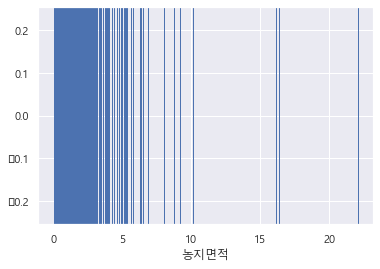

In [12]:
sns.rugplot(x='농지면적',data=data,height=1)
print(data['농지면적'].quantile(0.99)) #2.5 이상의 농지면적 모두 이상치로 판단
print(data['농지면적'].quantile(0.01)) #0.04이하의 농지면적 모두 이상치로 판단

In [13]:
data=data.query('0.04<농지면적<2.5')

# 합계 컬럼 이상치 제거

9.0
1.0
2     4276
5     1765
4     1720
1     1645
3     1171
6      736
9      442
7      205
8      180
10      24
12       7
11       5
13       1
Name: 합계, dtype: int64


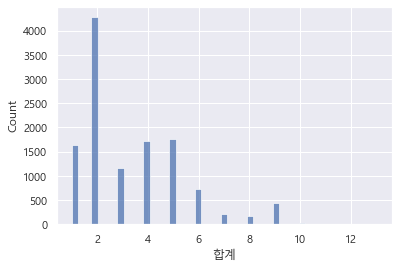

In [14]:
sns.histplot(x='합계',data=data)
print(data['합계'].quantile(0.99)) 
print(data['합계'].quantile(0.01)) 
print(data['합계'].value_counts()) #10 이상의 합계인원은 이상치로 판단하여 제거

In [15]:
data=data.query('합계<11')

# 연속형 변수 정규화

In [35]:
min_max_scaler=MinMaxScaler()
for i in data.columns:
    if (data[i].dtypes!='object') and (i not in ['비고','농업경영체','합계']):
        data[i]=min_max_scaler.fit_transform(data[[i]])
    else:
        pass

# 라벨 인코딩 진행(범주형 변수 수치형 변환)

In [36]:
label_encoder=LabelEncoder()
for i in data.columns:
    if data[i].dtypes=='object':
        data[i]=label_encoder.fit_transform(data[i])
    else:
        pass

# 모델 구축

# 데이터 분할

- 작물 종류 기준 데이터 분할

In [18]:
# 작물 종류 기준 층화 추출 Train Test 비율 8:2
X=data.drop(columns=['합계','농업경영체','비고']) #독립변수 Set
Y=data['합계'] #Target 변수 set
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,stratify=X['작물 종류'],random_state=42)

In [19]:
# Randomforest 모델 구축

model_reg=RandomForestRegressor(n_jobs=-1,random_state=42,n_estimators=200,max_depth=8)

In [20]:
model_reg.fit(X_train,Y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=-1, random_state=42)

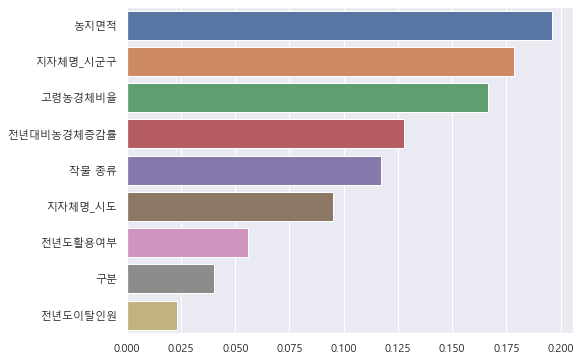

In [34]:
value_importance=model_reg.feature_importances_
value_importance=pd.Series(value_importance,index=X_train.columns)
value_importance=value_importance.sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=value_importance,y=value_importance.index)
plt.show()

In [25]:
pred=model_reg.predict(X_test)

In [26]:
pred=pd.DataFrame(pred,columns=['예측값'])
pred['예측값']=round(pred['예측값'],0)

# MAE & mse & Rmse & Rmspe

- MAE=실제값과 예측값 사이의 절대값의 평균=> 크면 클 수록 예측력이 낮은 것
- MSE=실제값과 예측값 사이의 차이를 제곱한 평균
- RMSE=MSE에 루트를 취한 값
- RMSPE=예측 오차를 실제값으로 나눈후 제곱하여 평균을 측정한 제곱근임

In [27]:
# MAE
def Evaluation_metric(actual,pred):
    print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
    print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
    print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')

In [28]:
Evaluation_metric(Y_test,pred=pred)

MAE: 1.31
MSE: 3.12
RMSE: 1.77
RMSPE: 52.36%


In [29]:
# Test data Set
test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
data_test['predict']=pred

In [30]:
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()

In [31]:
result_1=result.query('합계>10')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

MAE: 10.29
MSE: 225.38
RMSE: 15.01
RMSPE: 18.32%
